In [1]:
# IMPORT SOME MODULES =========================================================================
%pylab inline

from astropy.io import fits
from matplotlib.mlab import griddata
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import leastsq
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools as it
from string import join
import os

from densitycontour import densitycontour

from styles.paper import *
from styles.colors import *
from styles.labels import *

from tools.plots import *
from tools.stats import *
from tools.photometry import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
# sizes ---------------------------------------------------------------------------------------
NR = 100
# labels --------------------------------------------------------------------------------------
par_lbs = dict(
    M=r"$\log{M_\star/M\odot}$",
    log_t_M=r"$\left<\log{t_\star}\right>_M$",
    log_t_L=r"$\left<\log{t_\star}\right>_L$",
    log_Z_M=r"$\left<\log{Z_\star/Z\odot}\right>_M$",
    log_Z_L=r"$\left<\log{Z_\star/Z\odot}\right>_L$",
    Av=r"$A_V$"
)
res_lbs = dict(
    M=r"$\Delta\log{M_\star}$",
    log_t_M=r"$\Delta\left<\log{t_\star}\right>_M$",
    log_t_L=r"$\Delta\left<\log{t_\star}\right>_L$",
    log_Z_M=r"$\Delta\left<\log{Z_\star}\right>_M$",
    log_Z_L=r"$\Delta\left<\log{Z_\star}\right>_L$",
    Av=r"$\Delta A_V$"
)
con_lbs = dict(
    M=r"$\delta\log{M_\star}$",
    log_t_M=r"$\delta\left<\log{t_\star}\right>_M$",
    log_t_L=r"$\delta\left<\log{t_\star}\right>_L$",
    log_Z_M=r"$\delta\left<\log{Z_\star}\right>_M$",
    log_Z_L=r"$\delta\left<\log{Z_\star}\right>_L$",
    Av=r"$\delta A_V$"
)
tsize = "xx-small"

ssag_lb = r"\bf SSAG"
sdss_lb = r"\bf $ugriz$"
jpas_lb = r"\bf J-PAS"
spec_lb = r"\bf Spec."

sfgs_lb = r"\bf SFGs"
pags_lb = r"\bf PaGs"
algs_lb = r"\bf All Galaxies"

# colors --------------------------------------------------------------------------------------
ssag_cl = samples["dark"]
sdss_cl = seds["sdss"]
sdss_sg = segr["sdss"]
jpas_cl = seds["jpas"]
jpas_sg = segr["jpas"]
spec_cl = seds["spec"]
spec_sg = segr["spec"]

# output dir ----------------------------------------------------------------------------------
od = os.path.expandvars("$HOME/Documents/Publications/photofit_near_paper/")

In [3]:
ssag_tta = genfromtxt("../inputs/tta_cb13/ssag/set_catalog.txt", dtype=None, names=True)

mask_ws = ssag_tta["Av_lib"]<=1.5
mask_ws = mask_ws&((ssag_tta["name"]=="SSAG000058")|(ssag_tta["name"]=="SSAG000104"))
working_set = ssag_tta["name"][mask_ws]

ssag_tta = ssag_tta[mask_ws].repeat(NR)

lcolor = ssag_tta["u"]-ssag_tta["r"]
pags = lcolor>2.22
sfgs = ~pags
algs = pags|sfgs

fields = [field.replace("lib", "mod") for field in ssag_tta.dtype.names if "_lib" in field]
kw = [field.rstrip("_mod") for field in fields]

sdss_tta = genfromtxt("data/TTAChiTests/outs/sdss/dynbas_output.log", dtype=None, names=True)
jpas_tta = genfromtxt("data/TTAChiTests/outs/jpas/dynbas_output.log", dtype=None, names=True)
spec_tta = genfromtxt("data/TTAChiTests/outs/spec/dynbas_output.log", dtype=None, names=True)

ssag_tta["M_lib"] = log10(ssag_tta["M_lib"])
sdss_tta["M_mod"] = log10(sdss_tta["M_mod"])
jpas_tta["M_mod"] = log10(jpas_tta["M_mod"])
spec_tta["M_mod"] = log10(spec_tta["M_mod"])

ocolor = loadtxt("data/PhotoNearAnalysis/ur_color.txt")
jpas_obs = zeros(ocolor.size, dtype=zip(fields, ["<f8"]*6))
spec_obs = copy(jpas_obs)
for m in fields:
    spec_obs[m] = loadtxt("data/PhotoNearAnalysis/SPEC_{}.txt".format(m))
    jpas_obs[m] = loadtxt("data/PhotoNearAnalysis/JPAS_{}.txt".format(m))

In [4]:
print working_set[argmin(abs(lcolor[::NR]-1.5))], working_set[argmin(abs(lcolor[::NR]-2.5))]

SSAG000058 SSAG000104


In [5]:
print ssag_tta.dtype.names

('name', 'u', 'g', 'r', 'i', 'z', 'M_lib', 'log_t_M_lib', 'log_t_L_lib', 'log_Z_M_lib', 'log_Z_L_lib', 'Av_lib')


In [23]:
sfg_spec = spec_tta[ssag_tta["name"]==working_set[argmin(abs(lcolor[::NR]-1.5))]]
pag_spec = spec_tta[ssag_tta["name"]==working_set[argmin(abs(lcolor[::NR]-2.5))]]

sfg_jpas = jpas_tta[ssag_tta["name"]==working_set[argmin(abs(lcolor[::NR]-1.5))]]
pag_jpas = jpas_tta[ssag_tta["name"]==working_set[argmin(abs(lcolor[::NR]-2.5))]]

sfg_sdss = sdss_tta[ssag_tta["name"]==working_set[argmin(abs(lcolor[::NR]-1.5))]]
pag_sdss = sdss_tta[ssag_tta["name"]==working_set[argmin(abs(lcolor[::NR]-2.5))]]

sfg_true = ssag_tta[ssag_tta["name"]==working_set[argmin(abs(lcolor[::NR]-1.5))]][0]
pag_true = ssag_tta[ssag_tta["name"]==working_set[argmin(abs(lcolor[::NR]-2.5))]][0]

k_spec = 5301-1-sfg_spec["gen"]
k_jpas = 56-1-sfg_jpas["gen"]
k_sdss = 5-1-sfg_sdss["gen"]

E_spec = 0.99962243
E_jpas = 0.96153846
E_sdss = 0.0

In [33]:
sfg_jpas["input_file"][argmin(abs(sfg_jpas["chi_sq"]-E_jpas))]

'dynbasfit_SSAG000058_JPAS_038.log'

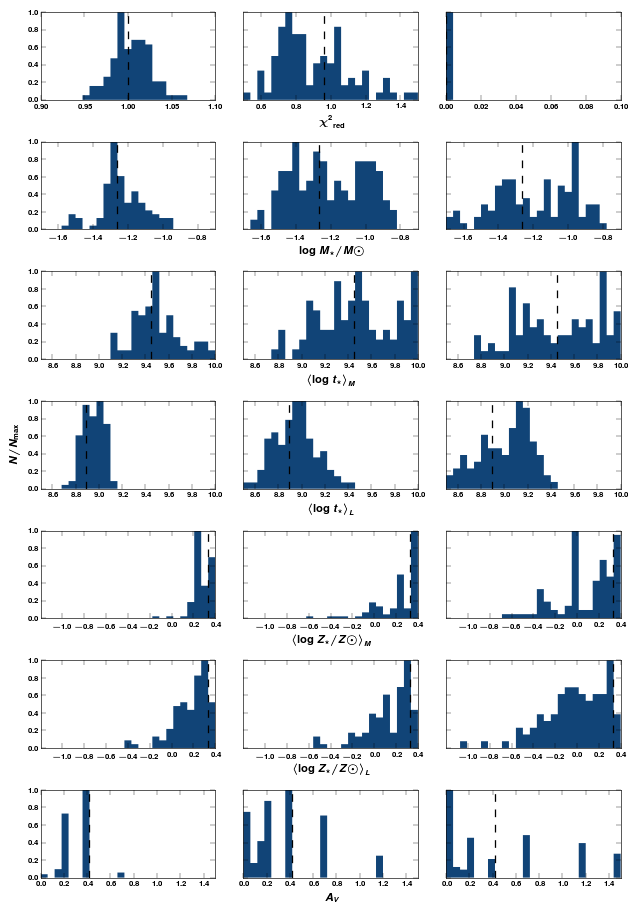

In [7]:
fig, axs = subplots(7, 3, sharey=True, figsize=(7,10))

ylim(0,1)

xlm = ((0.9,1.1),(0.5,1.5),(0,0.1)), ((-1.7,-0.7),)*3, ((8.5,10),)*3, ((8.5,10),)*3, ((-1.2,0.4),)*3, ((-1.2,0.4),)*3, ((0,1.5),)*3
kw = "chi_sq", "M", "log_t_M", "log_t_L", "log_Z_M", "log_Z_L", "Av"
tb = sfg_spec, sfg_jpas, sfg_sdss
df = k_spec, k_jpas, k_sdss

axs[3,0].set_ylabel(r"\bf $N/N_\text{max}$")
for i, j in it.product(xrange(axs.shape[0]), xrange(axs.shape[1])):
    x = kw[i]
    t = tb[j]
    k = mean(df[j])
    
    axs[i,j].set_xlim(xlm[i][j])
    if i!=0:
        n_max = histogram(t[x+"_mod"], 25, range=xlm[i][j])[0].max()
        axs[i,j].hist(t[x+"_mod"], 25, range=xlm[i][j], weights=1.0/n_max.repeat(NR), histtype="stepfilled", lw=0)
        axs[i,j].axvline(sfg_true[x+"_lib"], ls="--", color="k")
        
        if j==1: axs[i,j].set_xlabel(par_lbs[x])
    else:
        n_max = histogram(t[x], 25, range=xlm[i][j])[0].max()
        axs[i,j].hist(t[x], 25, range=xlm[i][j], weights=1.0/n_max.repeat(NR), histtype="stepfilled", lw=0)
        axs[i,j].axvline(max((k-2,0))/k, ls="--", color="k")
        
        if j==1: axs[i,j].set_xlabel(r"\bf ${\chi^2}_\text{red}$")
            
fig.tight_layout()

In [21]:
(k_jpas-2.0)/k_jpas

array([ 0.96153846,  0.96153846,  0.96153846,  0.96153846,  0.96153846,
        0.96153846,  0.96153846,  0.96153846,  0.96153846,  0.96153846,
        0.96153846,  0.96153846,  0.96153846,  0.96153846,  0.96153846,
        0.96153846,  0.96153846,  0.96153846,  0.96153846,  0.96153846,
        0.96153846,  0.96153846,  0.96153846,  0.96153846,  0.96153846,
        0.96153846,  0.96153846,  0.96153846,  0.96153846,  0.96153846,
        0.96153846,  0.96153846,  0.96226415,  0.96153846,  0.96153846,
        0.96153846,  0.96153846,  0.96153846,  0.96153846,  0.96153846,
        0.96153846,  0.96153846,  0.96153846,  0.96153846,  0.96153846,
        0.96153846,  0.96153846,  0.96153846,  0.96153846,  0.96153846,
        0.96153846,  0.96153846,  0.96153846,  0.96153846,  0.96226415,
        0.96153846,  0.96153846,  0.96153846,  0.96153846,  0.96153846,
        0.96153846,  0.96153846,  0.96226415,  0.96153846,  0.96153846,
        0.96153846,  0.96153846,  0.96153846,  0.96153846,  0.96

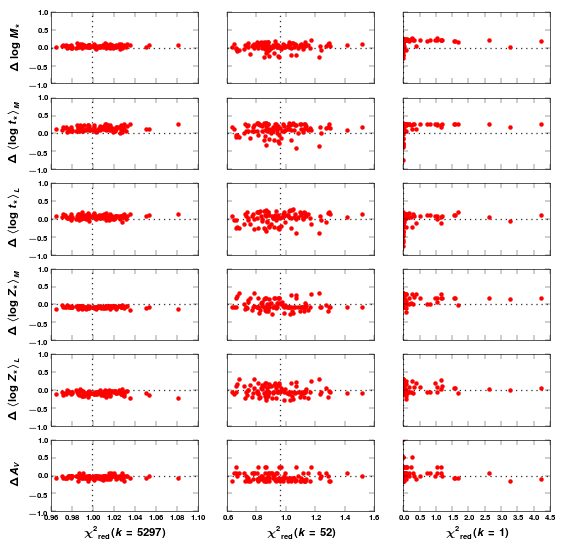

In [8]:
fig, axs = subplots(6, 3, sharex="col", sharey=True, figsize=(7,7))

ylim(-1,1)

kw = "M", "log_t_M", "log_t_L", "log_Z_M", "log_Z_L", "Av"
tb = pag_spec, pag_jpas, pag_sdss
df = k_spec, k_jpas, k_sdss

for i, j in it.product(xrange(axs.shape[0]), xrange(axs.shape[1])):
    x = kw[i]
    t = tb[j]
    k = mean(df[j])

    axs[i,j].axhline(ls=":", color=samples["dark"])
    axs[i,j].axvline(max((k-2,0))/k, ls=":", color=samples["dark"])
    axs[i,j].plot(t["chi_sq"], t[x+"_mod"]-pag_true[x+"_lib"], ".r", mew=0)
    
    if axs[i,j].is_last_row(): axs[i,j].set_xlabel(r"\bf ${\chi^2}_\text{red}(k=%d)$"%k)
    if axs[i,j].is_first_col(): axs[i,j].set_ylabel(res_lbs[x])